<a href="https://colab.research.google.com/github/lagonee23/price-prediction-models/blob/main/bitcoin_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암호화폐(BitCoin)의 가격 예측 모델


### 필요 모듈 설치
> [pyupbit](https://github.com/sharebook-kr/pyupbit) 모듈은 업비트라는 암호화폐 거래소의 API를 파이썬에서 쉽게 사용하기 위해 개발되었습니다.
해당 라이브러리를 통해 암호화폐의 현재 가격, 매매 주문 등의 정보를 쉽게 얻어올 수 있습니다.

In [2]:
!pip install pyupbit
!pip3 install xgboost
!pip3 install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.4 MB/s eta 0:00:00


In [3]:
import pyupbit

### 업비트에서 일봉(day)차트의 데이터 가져오기
* `open`: 시가
* `high`: 고가
* `low`: 저가
* `close`: 종가
* `volume`: 거래량
* `value`: 거래대금

> 업비트는 한국 거래소이므로 데이터의 단위는 원화(￦)입니다.

In [4]:
# UpBit에서 비트코인 가격 데이터 가져오기
df_origin = pyupbit.get_ohlcv("KRW-BTC", "day", count=2500, period=1)
df_origin

,open,high,low,close,volume,value
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2023-12-02 09:00:00,51710000.0,52833000.0,51645000.0,52603000.0,2689.116908,1.399282e+11
2023-12-03 09:00:00,52615000.0,53864000.0,52531000.0,53700000.0,3551.854502,1.884204e+11
2023-12-04 09:00:00,53761000.0,57337000.0,53690000.0,56920000.0,11395.027520,6.349280e+11
2023-12-05 09:00:00,56922000.0,60769000.0,56000000.0,60227000.0,9996.252712,5.807882e+11


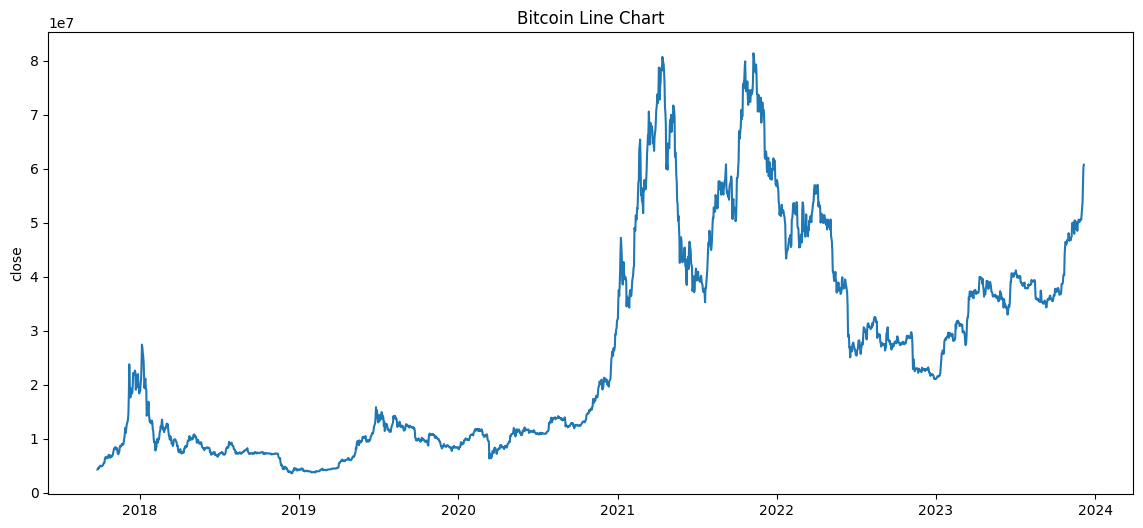

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_origin, x=df_origin.index, y='close')  # 비트코인 차트
plt.title('Bitcoin Line Chart')
plt.show()

## Model 1. Logistic Regression
---
> [로지스틱 회귀(logistic regression)](https://bluenoa.tistory.com/48)는 분류 문제를 해결하기 위한 강력한 통계 방법입니다. 종속 변수가 범주형 데이터(예: 이메일이 스팸인지 아닌지, 거래가 사기인지 아닌지 등)일 때 사용됩니다.

본 프로젝트에서는 가격이 몇 프로 올랐는지(혹은 내려갔는지), 거래량이 얼만큼 증감했는지에 따라 다음 날 가격 변화를 예측하려 합니다.

다음 날 가격이 올랐다면 `1`, 가격이 내려갔다면 `0`으로 표기합니다.

### 1-1. Feature engineering
* 새로운 컬럼을 생성
  * `candle`: 가격 변화율(%)
  * `volume_ratio`: 거래량의 변화율(%)
  * `profit_loss`: 다음 날의 손실(0)과 이득(1)을 나타내는 컬럼을 생성

In [10]:
df = df_origin.copy()

# 가격 변화율
df['candle'] = (df['close'] - df['open']) / df['open'] * 100
df

,open,high,low,close,volume,value,candle
2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,2.880267
2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,0.092657
2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,7.751041
2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,-1.524587
2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,1.548190
...,...,...,...,...,...,...,...
2023-12-02 09:00:00,51710000.0,52833000.0,51645000.0,52603000.0,2689.116908,1.399282e+11,1.726939
2023-12-03 09:00:00,52615000.0,53864000.0,52531000.0,53700000.0,3551.854502,1.884204e+11,2.062150
2023-12-04 09:00:00,53761000.0,57337000.0,53690000.0,56920000.0,11395.027520,6.349280e+11,5.876007
2023-12-05 09:00:00,56922000.0,60769000.0,56000000.0,60227000.0,9996.252712,5.807882e+11,5.806191


In [7]:
import numpy as np
import pandas as pd

df = df_origin.copy()

# 가격 변화율
candle_lst = [np.nan]
for c in range(len(df)-1):
  candle_ratio = (df['close'].iloc[c+1]-df['open'].iloc[c+1]) / abs(df['close'].iloc[c]-df['open'].iloc[c]+1)
  candle_lst.append(candle_ratio.round(2))

df['candle'] = candle_lst


# 전날 대비 거래량 비율
volume_lst = [np.nan]
for c in range(len(df)-1):
  volume_ratio = df['volume'].iloc[c+1] / df['volume'].iloc[c]
  volume_lst.append(volume_ratio.round(2))

df['volume_ratio'] = volume_lst


# 다음날의 손익 컬럼 생성(1은 수익, 0은 손실을 의미)
pl_lst = []
for p in range(len(df)-1):
  if df.iloc[p+1, 3]-df.iloc[p+1,0] > 0:
    pl_lst.append(1)
  elif df.iloc[p+1,3]-df.iloc[p+1,0] <= 0:
    pl_lst.append(0)
# 마지막 행의 손익을 알 수 없으므로 결측치 처리
pl_lst.append(np.nan)
df['profit_loss'] = pl_lst

# 첫 행과 마지막 행 삭제
df.dropna(inplace=True)

# 데이터 타입 변경
df = df.astype({'open':int, 'high':int, 'low':int, 'close':int, 'profit_loss':int})
df

,open,high,low,close,volume,value,candle,volume_ratio,profit_loss
2017-09-26 09:00:00,4317000,4418000,4311000,4321000,22.788340,9.950724e+07,0.03,0.17,1
2017-09-27 09:00:00,4322000,4677000,4318000,4657000,32.269662,1.448276e+08,83.73,1.42,0
2017-09-28 09:00:00,4657000,4772000,4519000,4586000,80.588243,3.721860e+08,-0.21,2.50,1
2017-09-29 09:00:00,4586000,4709000,4476000,4657000,59.352373,2.724558e+08,1.00,0.74,1
2017-09-30 09:00:00,4657000,4896000,4651000,4895000,19.998483,9.561476e+07,3.35,0.34,1
...,...,...,...,...,...,...,...,...,...
2023-12-01 09:00:00,50601000,52000000,50500000,51709000,4022.039333,2.066847e+11,8.27,1.45,1
2023-12-02 09:00:00,51710000,52833000,51645000,52603000,2689.116908,1.399282e+11,0.81,0.67,1
2023-12-03 09:00:00,52615000,53864000,52531000,53700000,3551.854502,1.884204e+11,1.22,1.32,1
2023-12-04 09:00:00,53761000,57337000,53690000,56920000,11395.027520,6.349280e+11,2.91,3.21,1


### 기준모델 설정
**기준 모델(Baseline Model)**은 예측 문제를 해결하기 위해 설정하는 단순한 모델이나 기준을 의미합니다. 이 모델은 일반적으로 복잡한 머신러닝 모델을 사용하기 전에, 문제를 얼마나 잘 이해하고 있는지, 어떤 방식으로 접근해야하는지를 판단하는 데 도움을 줍니다.

본 프로젝트에서는 타겟 변수의 **평균값**으로 기준모델을 설정합니다.



In [8]:
import numpy as np

df = df_origin.copy()  # 원본복사

predict = df['close'].mean()  # 평균값
print('Baseline model:', np.around(predict))

Baseline model: 25915753.0


### 특성과 타겟을 분리, 학습과 테스트 데이터를 분리

In [9]:
from sklearn.model_selection import train_test_split

features = ['candle',	'volume_ratio']
target = 'profit_loss'

X, y = df[features], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

KeyError: ignored

### 데이터 정규화 및 기준모델의 정확도 계산

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Scaling
scaler_std = StandardScaler()

X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)


# 기준모델
base = y_train.mode()[0]
baseline = len(y_train) * [base]
y_pred_base = len(y_test) * [base]
# 기준모델의 정확도
print("Train accuracy:", accuracy_score(y_train, baseline).round(3))
print("Test accuracy:", accuracy_score(y_test, y_pred_base).round(3))

### 기준모델의 Confusion Matrix

In [ ]:
y_true0 = y_test.value_counts()[0]
y_true1 = y_test.value_counts()[1]
confusion_base = pd.DataFrame(index = ['True 0', 'True 1'], data = {'Predicted 0':[0,0], 'Predicted 1':[y_true0,y_true1]})
confusion_base

### 모델의 정확도

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# 로지스틱 회귀
logCV_model = LogisticRegressionCV(cv=5)
logCV_model.fit(X_train_std, y_train)

# 로지스틱 회귀모델의 정확도
print("Train accuracy:", logCV_model.score(X_train_std, y_train).round(3))

### 평가지표

In [ ]:
from sklearn.metrics import classification_report

y_pred_test_log = logCV_model.predict(X_test_std)

print(classification_report(y_test, y_pred_test_log))

## 랜덤포레스트 모델

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(oob_score=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

print("Train accuracy:", rf_model.score(X_train, y_train).round(3))
print("Out-of-bag 샘플의 정확도:", rf_model.oob_score_.round(3))

In [ ]:
y_pred_test_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_test_rf))

## XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    eval_metric="error",
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.1,
    use_label_encoder=False
)

xgb_model.fit(X_train, y_train)

# 정확도
print("Traing accuracy", xgb_model.score(X_train, y_train).round(3))

y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))